In [1]:
import torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import os
import itertools
import sys
folder_path = './'
sys.path.insert(1, folder_path)
from train_pipeline import train
from SSL_pipeline import pretrain_SSL
import seaborn
seaborn.set_style('darkgrid')
plt.rcParams.update({'font.size': 14, 'lines.markersize': 8, 'lines.linewidth': 2})

In [2]:
random_seeds = [13531, 24642, 35753]
k_range = [4, 6, 8, 10] # number of transmitter-receiver pairs for training
num_train_samples_range = [256] # number of training samples
num_test_samples = 256 # number of test samples
modes = ['Supervised', 'Unsupervised'] # modes of training
figsize = (8, 6)
os.makedirs(folder_path + 'saved_training_data/results', exist_ok=True)
os.makedirs(folder_path + 'saved_training_data/models', exist_ok=True)

In [3]:
# perform SSL
for k, num_train_samples, seed in itertools.product(k_range, num_train_samples_range, random_seeds):
    num_samples = {'train': np.max(num_train_samples_range), 'test': num_test_samples}
    mode = 'SSL'
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k, str(num_samples), mode, seed)
    print('Now running experiment \"{}\" ...'.format(experiment_name))
    all_epoch_results, best_model = pretrain_SSL(k, num_samples, seed)
    torch.save(all_epoch_results, folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))
    torch.save(best_model, folder_path + 'saved_training_data/models/{}.pt'.format(experiment_name))

  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_13531" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_24642" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_35753" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_13531" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_24642" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_35753" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_13531" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_24642" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_35753" ...


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_13531" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_24642" ...


  0%|          | 0/2 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_SSL_seed_35753" ...


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


In [4]:
# fine-tune using supervised/unsupervised training
for k, num_train_samples, mode, seed in itertools.product(k_range, num_train_samples_range, modes, random_seeds):
    num_samples = {'train': num_train_samples, 'test': num_test_samples}
    # load pre-trained SSL model
    SSL_experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k, str(num_samples), 'SSL', seed)
    best_SSL_model = torch.load(folder_path + 'saved_training_data/models/{}.pt'.format(SSL_experiment_name))
    # start training
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}_afterSSL'.format(k, str(num_samples), mode, seed)
    print('Now running experiment \"{}\" ...'.format(experiment_name))
    all_epoch_results, best_model = train(k, num_samples, mode, seed, best_SSL_model)
    torch.save(all_epoch_results, folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))
    torch.save(best_model, folder_path + 'saved_training_data/models/{}.pt'.format(experiment_name))

  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_4_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_6_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642_afterSSL" ...


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Now running experiment "k_train_8_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Supervised_seed_35753_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_13531_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_24642_afterSSL" ...


  0%|          | 0/1 [00:00<?, ?it/s]

Now running experiment "k_train_10_num_train_samples_{'train': 256, 'test': 256}_mode_Unsupervised_seed_35753_afterSSL" ...


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


In [5]:
# load all results with SSL
all_epoch_results_SSL = dict()
for k, num_train_samples, mode, seed in itertools.product(k_range, num_train_samples_range, modes, random_seeds):
    num_samples = {'train': num_train_samples, 'test': num_test_samples}
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}_afterSSL'.format(k, str(num_samples), mode, seed)
    all_epoch_results_SSL[k, str(num_samples), mode, seed] = torch.load(folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))

# load all results without SSL
all_epoch_results = dict()
for k, num_train_samples, mode, seed in itertools.product(k_range, num_train_samples_range, modes, random_seeds):
    num_samples = {'train': num_train_samples, 'test': num_test_samples}
    experiment_name = 'k_train_{}_num_train_samples_{}_mode_{}_seed_{}'.format(k, str(num_samples), mode, seed)
    all_epoch_results[k, str(num_samples), mode, seed] = torch.load(folder_path + 'saved_training_data/results/{}.json'.format(experiment_name))

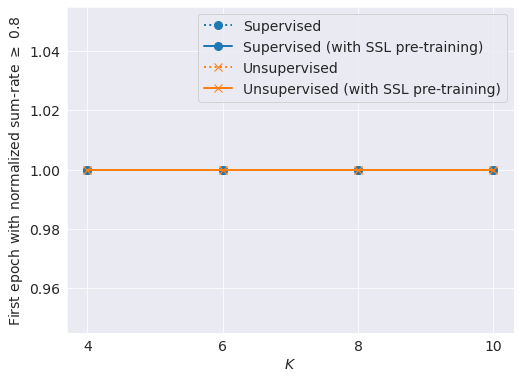

In [7]:
# convergence behavior
plt.figure(figsize=figsize)
threshold = 0.8
markers = ['o', 'x']
linestyles = [':', '-']
num_samples = {'train': np.max(num_train_samples_range), 'test': num_test_samples}
for i, mode in enumerate(modes):
    # without SSL
    epochs_all_seeds = []
    for seed in random_seeds:
        test_epochs = []
        for k in k_range:
            res = all_epoch_results[k, str(num_samples), mode, seed]
            first_epoch_above_threshold = 1 + np.where(np.array(res['test', k, 'normalized_sum_rate']) >= threshold)[0][0]
            test_epochs.append(first_epoch_above_threshold)
        epochs_all_seeds.append(test_epochs)
    plt.plot(k_range, np.mean(epochs_all_seeds, axis=0), linestyles[0], label=mode, marker=markers[i])
    
    # without SSL
    epochs_all_seeds = []
    for seed in random_seeds:
        test_epochs = []
        for k in k_range:
            res = all_epoch_results_SSL[k, str(num_samples), mode, seed]
            first_epoch_above_threshold = 1 + np.where(np.array(res['test', k, 'normalized_sum_rate']) >= threshold)[0][0]
            test_epochs.append(first_epoch_above_threshold)
        epochs_all_seeds.append(test_epochs)
    plt.plot(k_range, np.mean(epochs_all_seeds, axis=0), linestyles[1], label=mode + ' (with SSL pre-training)', marker=markers[i], color=plt.gca().lines[-1].get_color())
plt.xlabel(r'$K$')
plt.ylabel(r'First epoch with normalized sum-rate $\geq$ 0.8')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()